In [65]:
library(bnlearn)
library(Rgraphviz)

### 1 Building a DAG

#### (a) Write out the factorization of the joint distribution implied by the DAG using mathematical notation

$P(A,S,E,O,R,T) = P(A).P(S).P(E|A,S).P(O|E).P(R|E).P(T|O,R)$

#### (b) Rewrite the above factorization in bnlearn’s string representation.

In [4]:
dagstring = '[A][S][E|A:S][O|E][R|E][T|O:R]'

#### (c) Use this to create a DAG in bnlearn.

In [5]:
dag = model2network(dagstring)

#### (d) Print the class of the DAG object.

In [6]:
class(dag)

[1] "bn"

#### (e) Use graphviz.plot to plot the DAG.

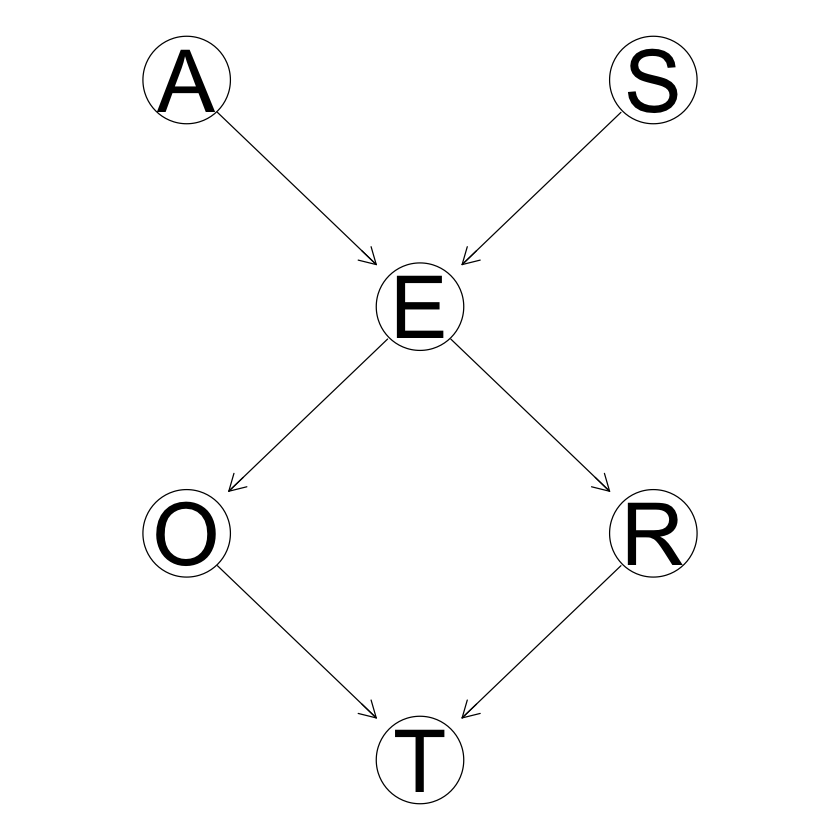

In [7]:
graphviz.plot(dag)

### 2 Experimenting with graph utilities

#### (a) Extract and print the nodes and arcs of the DAG you created in previous questions.

In [8]:
nodes(dag)

[1] "A" "E" "O" "R" "S" "T"

In [9]:
arcs(dag)

from,to
A,E
S,E
E,O
E,R
O,T
R,T


#### (b) Extract and print the parents and the children of each node using parents and children functions.

In [10]:
for (node in nodes(dag))
    {
    cat("Node:", node, ";", "Parents:", parents(dag, node), ";", "Children:", children(dag, node), "\n")
    }

Node: A ; Parents:  ; Children: E 
Node: E ; Parents: A S ; Children: O R 
Node: O ; Parents: E ; Children: T 
Node: R ; Parents: E ; Children: T 
Node: S ; Parents:  ; Children: E 
Node: T ; Parents: O R ; Children:  


#### (c) Use the mb function to extract the Markov blanket of A, E, and T.

In [11]:
for (node in c("A","E","T"))
    {
    cat("Node:", node, ";", "Markov blanket:", mb(dag,node), "\n")
    }

Node: A ; Markov blanket: E S 
Node: E ; Markov blanket: A O R S 
Node: T ; Markov blanket: O R 


#### (d) Describe, in terms of the joint probability distribution and NOT in terms of the DAG the definition of a Markov blanket.

Assuming the Markov blanket of node $A$ is denoted by $MB(A)$:

Node $A$ is conditionally independent of any node $B \notin$ $MB(A)$, given $MB(A)$

i.e. $P(A|MB(A),O,R,T) = P(A|MB(A))$

It works similarly for other nodes in the DAG.

#### (e) How do you identify the Markov blanket from the DAG?

The Markov blanket of a node $A$ is the set of all parents, children, and other parents of children of $A$.

### 3 Conditional probability distribution (CPD) parameter estimation

#### (a) Fit the parameters of the DAG from the data stored in survey2.txt using Bayesian estimation, and save the result into an object of class bn.fit.

In [12]:
data = read.table("~/Desktop/CS 7290/causalML/HW/hw1_release/survey2.txt",header=TRUE)

In [13]:
bn.bayes = bn.fit(dag, data, method="bayes")

In [14]:
bn.bayes


  Bayesian network parameters

  Parameters of node A (multinomial distribution)

Conditional probability table:
     adult       old     young 
0.3575391 0.1578417 0.4846193 

  Parameters of node E (multinomial distribution)

Conditional probability table:
 
, , S = F

      A
E          adult       old     young
  high 0.6389365 0.8446809 0.1558105
  uni  0.3610635 0.1553191 0.8441895

, , S = M

      A
E          adult       old     young
  high 0.7191617 0.8913043 0.8099825
  uni  0.2808383 0.1086957 0.1900175


  Parameters of node O (multinomial distribution)

Conditional probability table:
 
      E
O            high        uni
  emp  0.98016416 0.96531303
  self 0.01983584 0.03468697

  Parameters of node R (multinomial distribution)

Conditional probability table:
 
       E
R             high        uni
  big   0.71751026 0.93824027
  small 0.28248974 0.06175973

  Parameters of node S (multinomial distribution)

Conditional probability table:
         F         M 
0.54689

#### (b) Play with the Bayesian prior parameter iss and report the changes in the parameters learned from Bayesian network. Explain the changes.

The iss parameter is the weight assigned to our prior distribution - the more weight we assign, the more it will update our likelihood function. The point of a prior is to smooth distributions so that we are not assigning too much weight to the maximum likelihood estimate, and leave room for domain knowledge/events that we have not yet observed.

Let's take Occupation as an example. It depends on Education in this DAG. Assigning a value of 1 to iss gives us the following estimates:

In [15]:
bn.fit(dag, data, method="bayes", iss=1)['O']

$O

  Parameters of node O (multinomial distribution)

Conditional probability table:
 
      E
O            high        uni
  emp  0.98016416 0.96531303
  self 0.01983584 0.03468697


So we see that those who attended high school/university are both more likely to be employed, with a higher probability for high school graduates.

When we increase iss to 50 - say we saw 50 examples where our dirichlet prior distribution was valid, we will see that our probabilities for those who are employed given education go down, and those who are self employed go up.

In [16]:
bn.fit(dag, data, method="bayes", iss=50)['O']

$O

  Parameters of node O (multinomial distribution)

Conditional probability table:
 
      E
O           high       uni
  emp  0.9500000 0.9296875
  self 0.0500000 0.0703125


Further increasing it to 300 - half of our data sample size, will show us a more significant change in the probability estimates:

In [17]:
bn.fit(dag, data, method="bayes", iss=300)['O']

$O

  Parameters of node O (multinomial distribution)

Conditional probability table:
 
      E
O           high       uni
  emp  0.8407767 0.8089888
  self 0.1592233 0.1910112


So we can use this to weight our domain knowledge about the prior probabilities, in a way indicating our confidence in the prior estimate.

### 4 Graph manipulation
#### (a) Create a copy of the DAG (e.g. dag2 <- dag). Remove the arc from Education to Occupation, and plot the result with graphviz.plot.

In [18]:
dag2 = dag
dag2 = drop.arc(dag2, "E", "O")

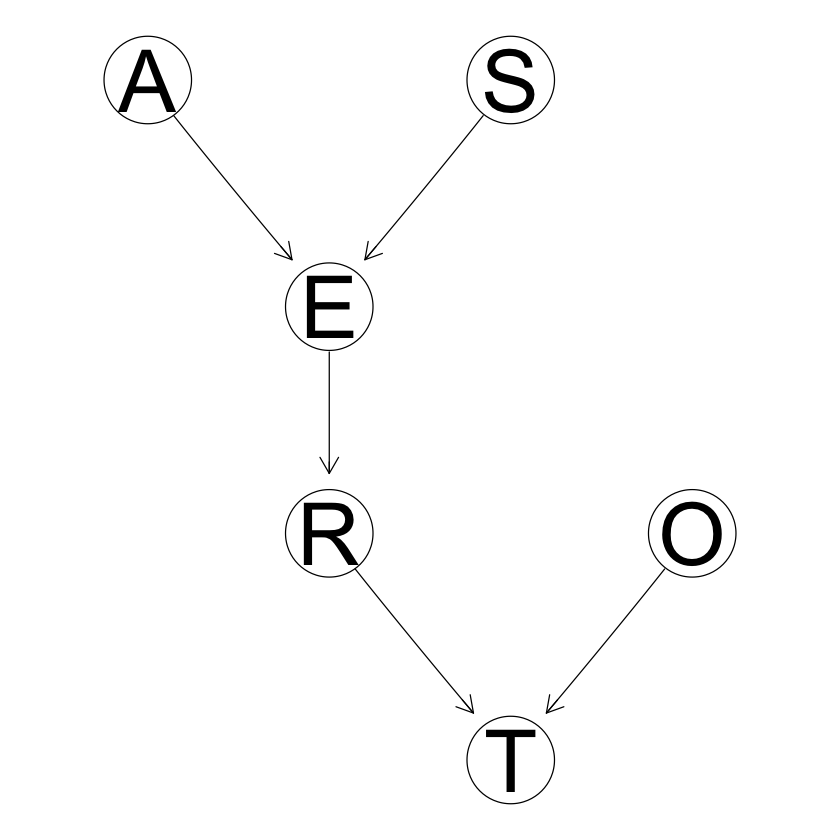

In [19]:
graphviz.plot(dag2)

#### (b) Fit the parameters of the modified network. Which local distributions change, and how?

In [20]:
bn.mutil = bn.fit(dag2, data, method="bayes")

In [21]:
c("DAG 1", bn.bayes['O'], "DAG 2", bn.mutil['O'])

[[1]]
[1] "DAG 1"

$O

  Parameters of node O (multinomial distribution)

Conditional probability table:
 
      E
O            high        uni
  emp  0.98016416 0.96531303
  self 0.01983584 0.03468697

[[3]]
[1] "DAG 2"

$O

  Parameters of node O (multinomial distribution)

Conditional probability table:
        emp       self 
0.97352496 0.02647504 


In [22]:
c("DAG 1", bn.bayes['T'], "DAG 2", bn.mutil['T'])

[[1]]
[1] "DAG 1"

$T

  Parameters of node T (multinomial distribution)

Conditional probability table:
 
, , R = big

       O
T              emp       self
  car   0.71084719 0.68553459
  other 0.13887569 0.15723270
  train 0.15027712 0.15723270

, , R = small

       O
T              emp       self
  car   0.54655295 0.72549020
  other 0.07746979 0.25490196
  train 0.37597726 0.01960784


[[3]]
[1] "DAG 2"

$T

  Parameters of node T (multinomial distribution)

Conditional probability table:
 
, , R = big

       O
T              emp       self
  car   0.71084719 0.68553459
  other 0.13887569 0.15723270
  train 0.15027712 0.15723270

, , R = small

       O
T              emp       self
  car   0.54655295 0.72549020
  other 0.07746979 0.25490196
  train 0.37597726 0.01960784



Only the distribution for Occupation changes, since it is no longer dependent on the values of Education. Its values are now just the prior distribution of Occupation, i.e. $P(O=\text{emp})$ and $P(O=\text{self})$.

Even though the values of Transport depend on Occupation, $P(T|O)$ is already defined for all possible values of Occupation, so there is no change to that distribution.

### 5 Markov equivalence (12 points)
#### (a) Compute and plot the PDAG of the DAG for the survey data using the cpdag function. Call this PDAG P1 and the original DAG D1. How does P1 and D1 compare? Explain any similarities or differences.

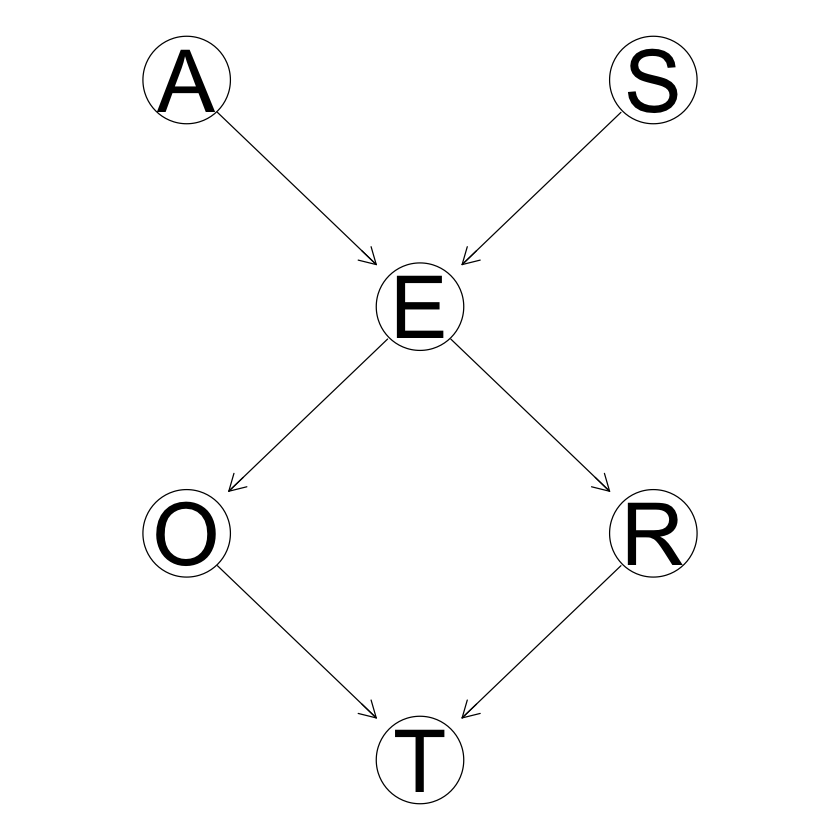

In [43]:
p1 = cpdag(dag)
p1 = bn.fit(p1,data,method="bayes")
d1 = dag
graphviz.plot(p1)

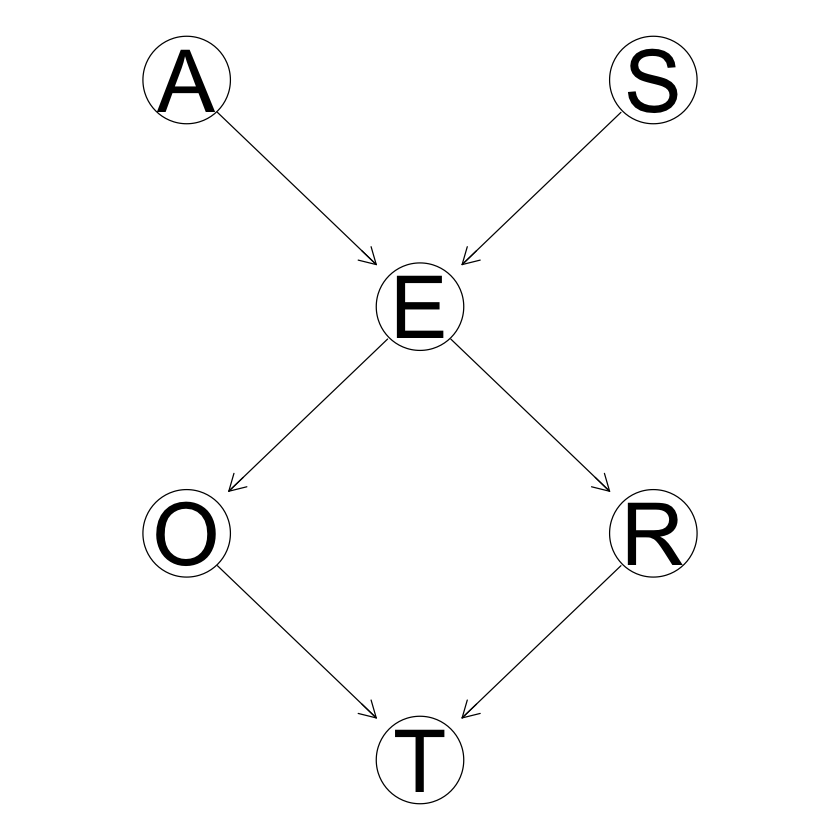

In [32]:
graphviz.plot(d1)

P1 and D1 are exactly the same here. This means that there are no other PDAGs that are statistically equivalent to D1.

The reasons that no edges in this graph can be inverted to create an equivalent graph are:

- the relation between A, E, and S as well as the one between O, R and T is in the form a V-structure. 
- in the case of A,E, and S, the graph implies the following relationships:
    - A and S are independent of each other, and conditionally dependent on each other, given E
    - reversing either of the edges (A,E) or (S,E) would introduce dependency of one node on the other, changing the constraints in the graph
    
- for the relation between E, O and R - the current graph relationship suggests O and R and dependent on each other and conditionally independent of each other given E. 
    - reversing these edges would create a V structure with different conditional dependence assumptions
    - this also changes dependencies upstream and downstream

#### (b) Create a DAG D2 that is the same as D1 except that it has a new arc from Occupation to Residence. This makes sense because surely somebody’s job determines where they live (or is it the other way around?). Note that this is a fine example of applying domain knowledge about the data generative process in causal model development. Plot the result with graphviz.plot.

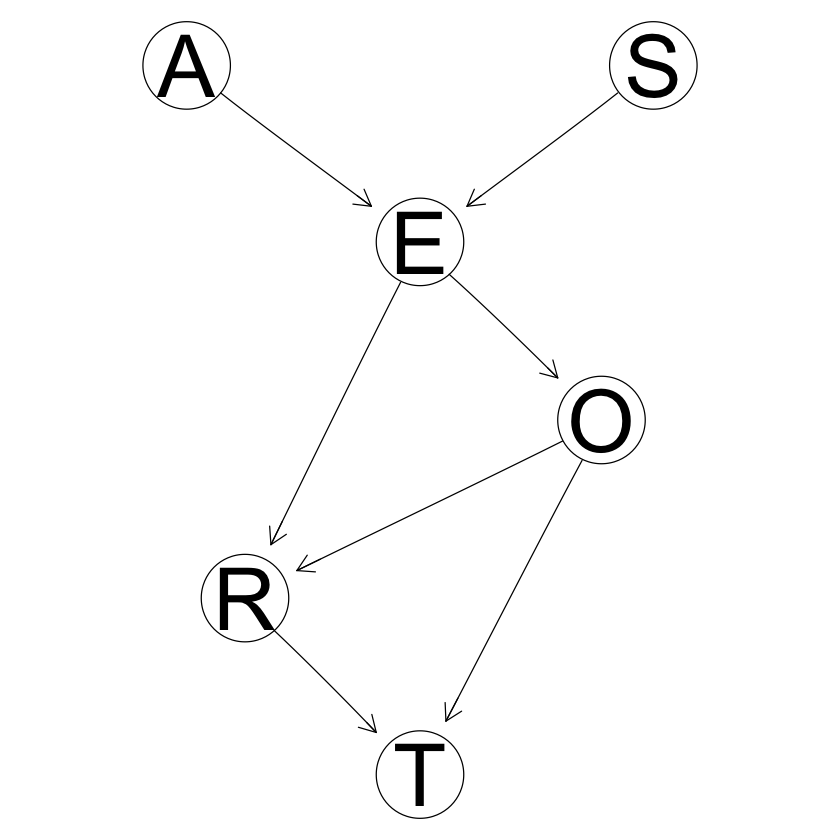

In [61]:
d2 = d1
d2 = set.arc(d2, "O", "R")
graphviz.plot(d2)

#### (c) Now recompute a PDAG P2 from D2. What, if anything, is different between P1 and P2 and what explains these differences or lack of differences?

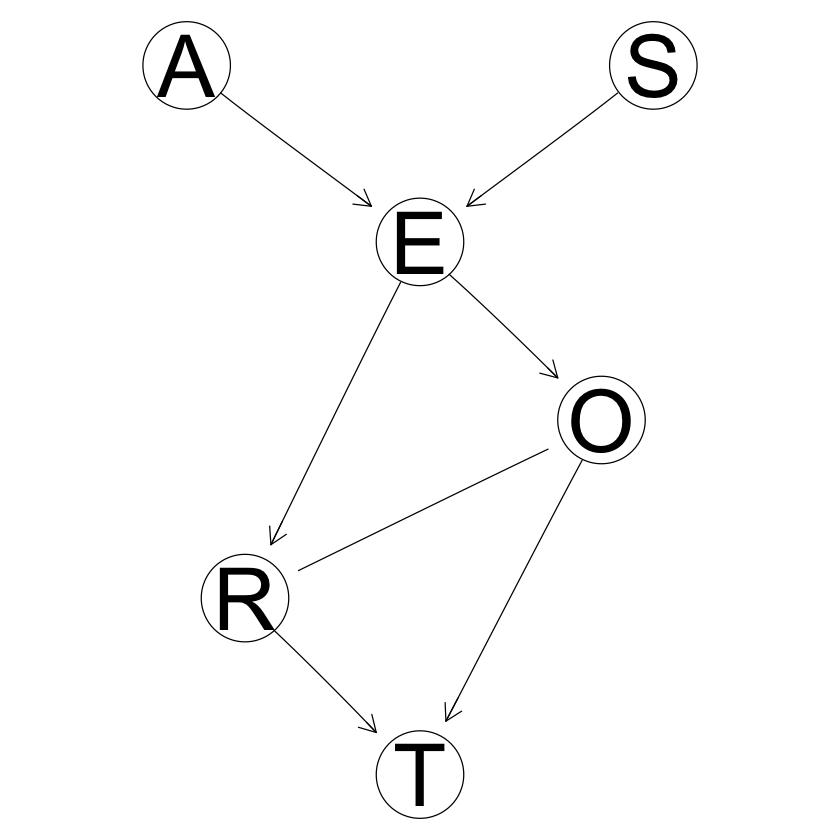

In [41]:
p2 = cpdag(d2)
graphviz.plot(p2)

In P2, the arc between O and R is undirected. This is because changing the direction of this arc does not introduce any new constraints - the relationships between O and R and all other nodes remains the same in both cases.

#### (d) Create a third DAG D3 that is different from the second DAG (with the O->R edge) but is in the same Markov equivalence class. Do this by reasoning about P2 – in other words look at P2 and create another DAG D3, such that cpdag(D3) will also produce P2. Plot D3.

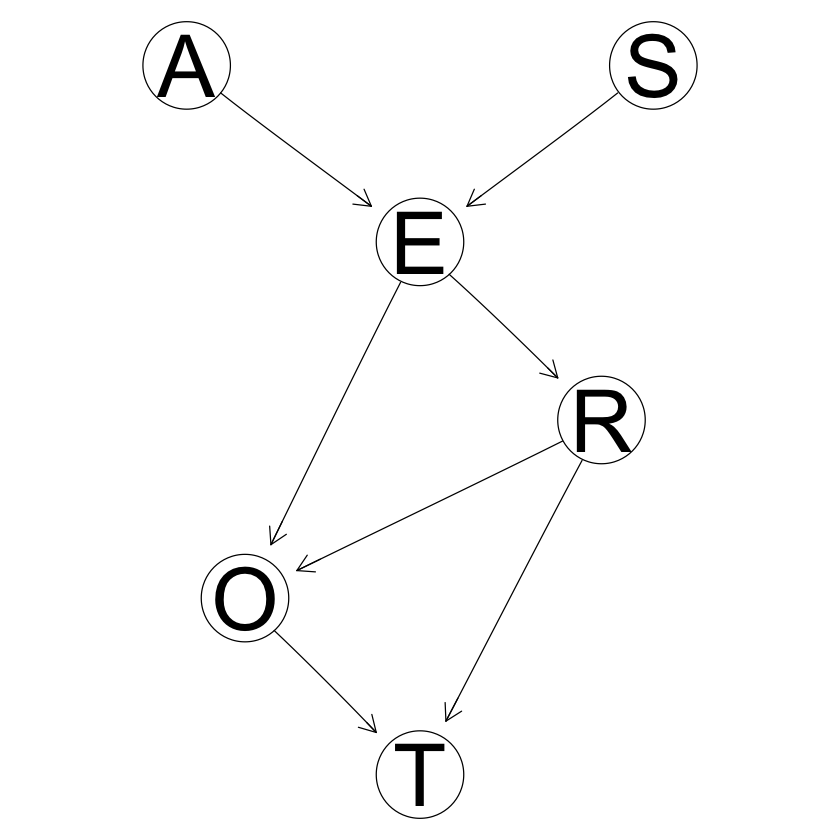

In [44]:
d3 = d1
d3 = set.arc(d3, "R", "O")
graphviz.plot(d3)

#### (e) Calculate the log-likelihood of the data given D2 and the log-likelihood of the data given D3. These values should be the same, explain why. You can use the score function with the argument type = 'loglik, or you can simply se the logLik function, which is just a wrapper for score. You don’t need to provide paramter values for the CPDs of the DAG, score will estimate them for you.

In [70]:
bnlearn::score(d2,data,type="loglik")

[1] -2350.686

In [71]:
bnlearn::score(d3,data,type="loglik")

[1] -2350.686

These values are the same since d2 and d3 are in the same equivalence class. This means that the models are statisticallly equivalent and they both give the same log-likelihood estimates.